In [28]:
import torch
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torch.optim import lr_scheduler
from torchvision import transforms

import numpy as np
import pandas as pd
from PIL import Image
import time

import librosa
import librosa.display

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix

import deepdish as dd

import utils
from trainer.UNet import UNet
from trainer.utils import FMADataset

In [4]:
X = dd.io.load('data/fma_preprocessed/X_3.h5')
Y = dd.io.load('data/fma_preprocessed/Y_3.h5')

In [5]:
# standardize images
mean = np.mean(X['training'])
std = np.std(X['training'])

for k in X.keys():
    X[k] = (X[k] - mean) / std

In [73]:
test_acc = 0.

test_set = FMADataset(X, Y, mode='test')
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

model_paths = [
    'results/model_intermediate0.4888_B42_LR0.0004042345079351265.pth',
    'results/model_intermediate0.4892_B42_LR0.0002607264726285735.pth',
]

# Load model
model = UNet()
model.load_state_dict(torch.load(model_paths[1], map_location=torch.device('cpu')))
model.eval()

Y_preds = np.ndarray(0)
for xs, ys in test_loader:
    probs = model(xs)
    ys = torch.max(ys, 1)[1]
    pred = probs.cpu().argmax(1)
    test_acc += (pred == ys).sum()
    
    Y_preds = np.concatenate((Y_preds, pred))
    
test_acc /= len(test_loader.dataset)

print(test_acc)

/home/jupyter/music-genre-classification/trainer/UNet.py:16: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(m.weight)


tensor(0.4271)


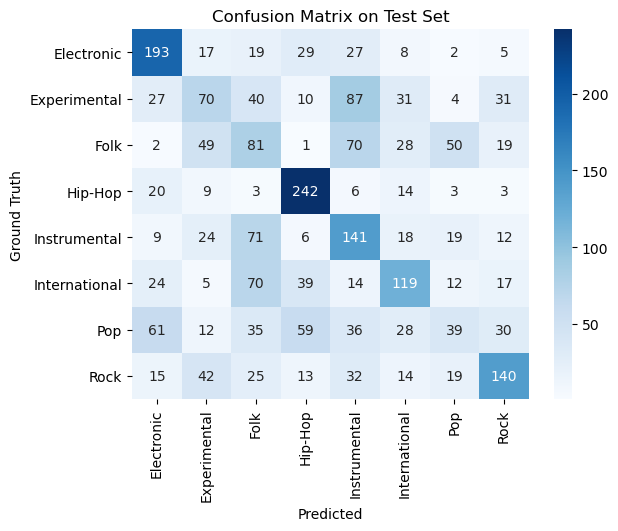

In [75]:
Y_labels = np.argmax(Y['test'], 1)

cf_matr = confusion_matrix(Y_labels, Y_preds.astype(int))
axis_labels = ['Electronic', 'Experimental', 'Folk', 'Hip-Hop', 'Instrumental', 'International', 'Pop', 'Rock']

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
sns.heatmap(cf_matr, xticklabels=axis_labels, yticklabels=axis_labels, annot=True, fmt='g', cmap='Blues', ax=ax)
ax.set_title('Confusion Matrix on Test Set')
ax.set_xlabel('Predicted')
ax.set_ylabel('Ground Truth')
fig.savefig('heatmap.png', transparent=True, bbox_inches='tight')

(8, 8)